# Classifiers - low vs mid vs high complexity - no TFv1
Exploring different classifiers with different autoencoders. No contractive autoencoder because it needs TFv1 compatibility.

#### Table of contents:  

autoencoders:  
[Undercomplete Autoencoder](#Undercomplete-Autoencoder)  
[Sparse Autoencoder](#Sparse-Autoencoder)  
[Deep Autoencoder](#Deep-Autoencoder)  

classifiers:  
[Simple dense classifier](#Simple-dense-classifier)  
[LSTM-based classifier](#LSTM-based-classifier)  
[kNN](#kNN)  
[SVC](#SVC)  
[Random Forest](#Random-Forest)  
[XGBoost](#XGBoost)  

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import pandas
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy']

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier

import json
from datetime import datetime
import warnings
import matplotlib.pyplot as plt

In [2]:
import random

random.seed(1)
np.random.seed(4)
tf.random.set_seed(2)

In [3]:
# Start the notebook in the terminal with "PYTHONHASHSEED=0 jupyter notebook" 
# or in anaconda "set PYTHONHASHSEED=0" then start jupyter notebook
import os
if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 before starting the Jupyter server to get reproducible results.")

This is modfied original author's code for reading data:

In [4]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [5]:
def get_task_complexities_timeframes_br_hb(path, ident, seconds):
    """Returns raw data along with task complexity class.
    TODO: join functions. Add parameter to choose different task types and complexities"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))
    breathing = np.empty((0,12))
    heartbeat = np.empty((0,10))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    
    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17
        tmp_tasks_data = np.empty((0, seconds*samp_rate))
        tmp_tasks_y = np.empty((0, 1))
        tmp_breathing = np.empty((0,12))
        tmp_heartbeat = np.empty((0,10))
        
        ### task complexity classification
#         if cog_res['task_complexity'][task_num_table] == 'medium':
#             continue
        # if cog_res['task_label'][task_num_table] == 'FA' or cog_res['task_label'][task_num_table] == 'HP':
        #     continue
#         if cog_res['task_label'][task_num_table] != 'NC':
#             continue
            
        map_compl = {
            'low': 0,
            'medium': 2,
            'high': 1
        }

        
        for j in range(10):
            new_end = int(busy_n[task_num_table][1] - j * samp_rate)
            new_start = int(new_end - samp_rate*30)
            dataextract = dataextractor.DataExtractor(data[0][new_start:new_end],
                                                      data[1][new_start:new_end], samp_rate)
            # get extracted features for breathing
            tmpBR = dataextract.extract_from_breathing_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            #get extracted features for heartbeat
            tmpHB = dataextract.extract_from_heartbeat_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            
            try:
                
                tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract.y[-samp_rate * seconds:]))
                tmp_tasks_y = np.vstack((tmp_tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))

                tmp_breathing = np.vstack((tmp_breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                
            except ValueError:
#                 print(ident)
                continue

            tasks_data = np.vstack((tasks_data, dataextract.y))
            tasks_y = np.vstack((tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))
            breathing = np.vstack((breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            heartbeat = np.vstack((heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            
    return tasks_data, tasks_y, breathing, heartbeat

In [6]:
def get_data_from_idents_br_hb(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    brs = np.empty((0,12))
    hbs = np.empty((0,10))
    combined = np.empty((0,22))
    
    # was gettign some weird warnings; stack overflow said to ignore them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in idents:
            #x, y, br, hb = get_busy_vs_relax_timeframes_br_hb(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
            # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes
            x, y, br, hb = get_task_complexities_timeframes_br_hb(path, i, seconds)
            
            data = np.vstack((data, x))
            ys = np.vstack((ys, y))
            brs = np.vstack((brs, br))
            hbs = np.vstack((hbs, hb))
        combined = np.hstack((brs,hbs))
    
    return data, ys, brs, hbs, combined

In [7]:
# Accs is a dictionary which holds 1d arrays of accuracies in each key
# except the key 'test id' which holds strings of the id which yielded the coresponding accuracies
def print_accs_stats(accs):
    
    printDict = {}
    # loop over each key
    for key in accs:
    
        if (key == 'test id'):
            # skip calculating ids
            continue
        printDict[key] = {}
        tmpDict = printDict[key]
        # calculate and print some statistics
        tmpDict['min'] = np.min(accs[key])
        tmpDict['max'] = np.max(accs[key])
        tmpDict['mean'] = np.mean(accs[key])
        tmpDict['median'] = np.median(accs[key])
    
    print(pandas.DataFrame.from_dict(printDict).to_string())

In [8]:
def clear_session_and_set_seeds():
    # clear session and set seeds again
    K.clear_session()
    random.seed(1)
    np.random.seed(4)
    tf.random.set_seed(2)

## Prepare data

Initialize variables:

In [9]:
# initialize a dictionary to store accuracies for comparison
accuracies = {}

# used for reading the data into an array
seconds = 30  # time window length
samp_rate = 43  # hard-coded sample rate
phase_shape = np.empty((0, samp_rate*seconds))
y_shape = np.empty((0, 1))
breathing_shape = np.empty((0,12))
heartbeat_shape = np.empty((0,10))
combined_shape = np.empty((0,22))
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../StudyData/'


# change to len(idents) at the end to use all the data
n = len(idents)

In [10]:
# load all phase data to use for training autoencoders
phase_all_train = get_data_from_idents_br_hb(path, idents[:-2], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_train = MinMaxScaler().fit_transform(phase_all_train.T).T

# load all validation phase data to use for training autoencoders
phase_all_valid = get_data_from_idents_br_hb(path, idents[-2:], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_valid = MinMaxScaler().fit_transform(phase_all_valid.T).T

In [11]:
# Holds all the data so it doesnt have to be read from file each time
data_dict = {}

Fill the data dictionary:

In [12]:
for ident in idents:
    
    # initialize ident in 
    data_dict[ident] = {}
    tmpDataDict = data_dict[ident]
    
    # read data
    phase, y, breathing, heartbeat, combined = get_data_from_idents_br_hb(path, [ident], seconds)
    
    # load data into dictionary
    tmpDataDict['phase'] = phase
    tmpDataDict['y'] = y
    tmpDataDict['breathing'] = breathing
    tmpDataDict['heartbeat'] = heartbeat
    tmpDataDict['combined'] = combined

## Autoencoders  
Train autoencoders to save their encoded representations in the data dictionary:

In [13]:
# AE Training params
batch_size = 128
epochs = 1000
encoding_dim = 30
ae_encoded_shape = np.empty((0,encoding_dim))

In [14]:
def compare_plot_n(data1, data2, plot_n=12):
    
    #plot data1 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data1[i])

    #plot data2 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data2[i])

#### Undercomplete Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [15]:
def undercomplete_ae(x, encoding_dim=64, encoded_as_model=False):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.125, name="dropout", seed=42)(input_data)
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu', name="encoded")(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    autoencoder = Model(input_data, decoded)
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [16]:
clear_session_and_set_seeds()
uc_ae, uc_enc = undercomplete_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
uc_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

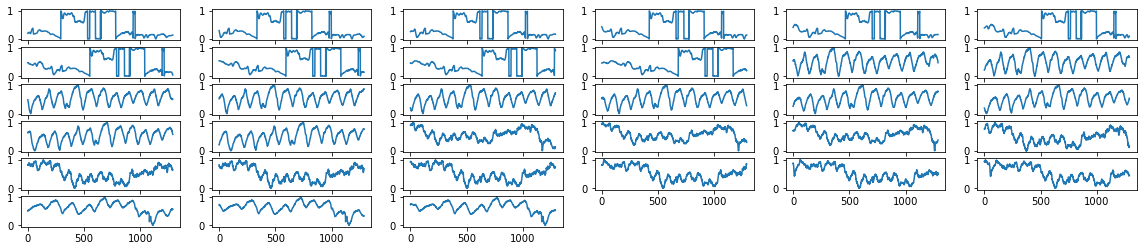

<Figure size 432x288 with 0 Axes>

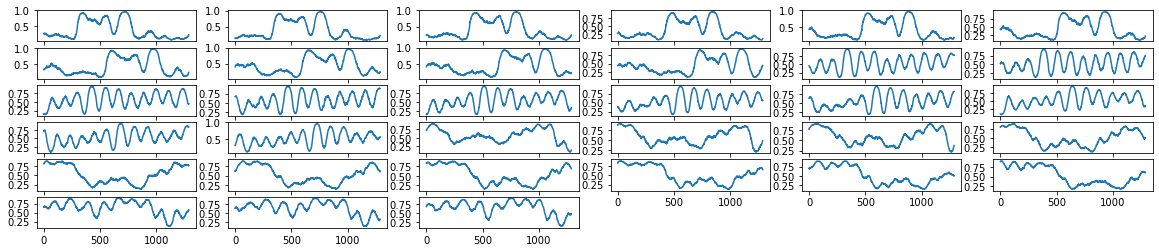

In [17]:
data2 = uc_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

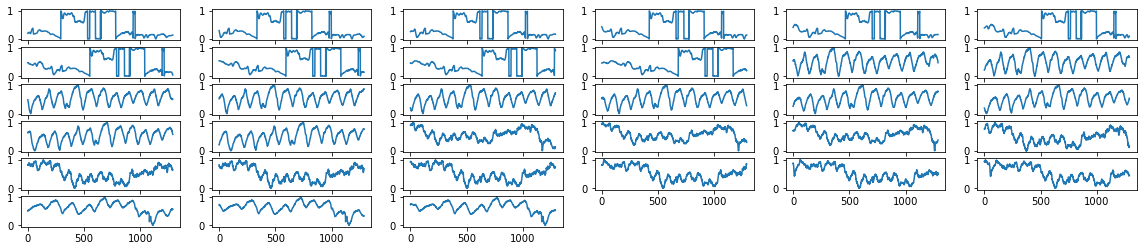

<Figure size 432x288 with 0 Axes>

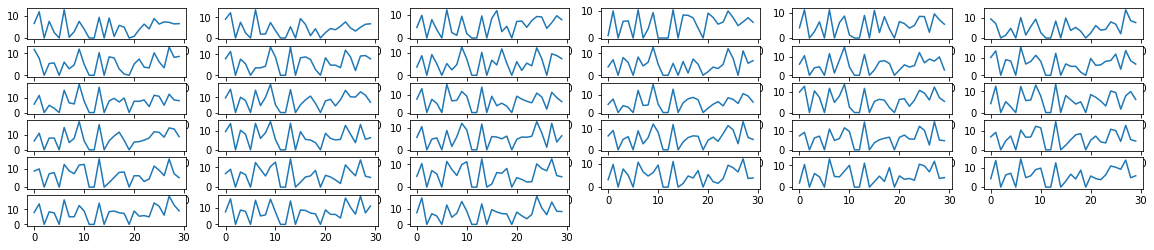

In [18]:
data2 = uc_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Store the encoded representations in the data dictionary:

In [19]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    uc_data = uc_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['undercomplete_encoded'] = uc_data

#### Sparse Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [20]:
def sparse_ae(x, encoding_dim=64, encoded_as_model=False):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.125, name="dropout", seed=42) (input_data)
    # "encoded" is the encoded representation of the input
    # add a sparsity constraint
    encoded = Dense(encoding_dim, activation='relu', name="encoded",
                    activity_regularizer=regularizers.l1(10e-5))(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_data, decoded, name="sparse_ae")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [21]:
clear_session_and_set_seeds()
sp_ae, sp_enc = sparse_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
sp_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

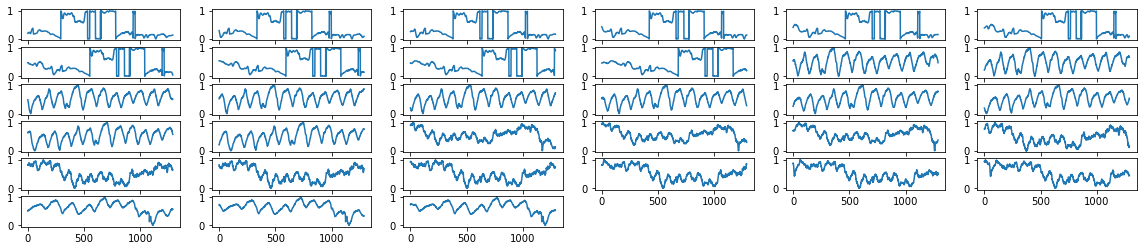

<Figure size 432x288 with 0 Axes>

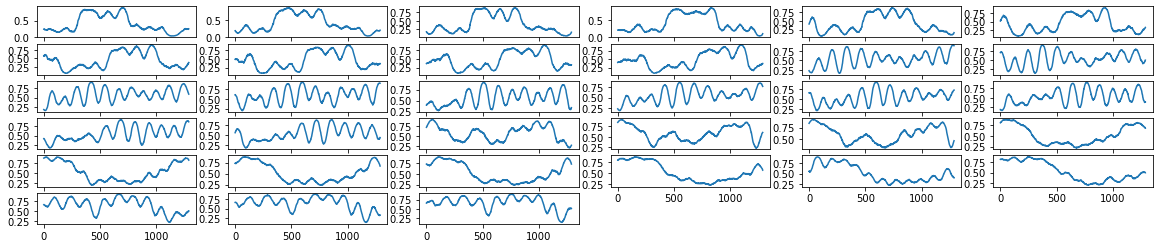

In [22]:
data2 = sp_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

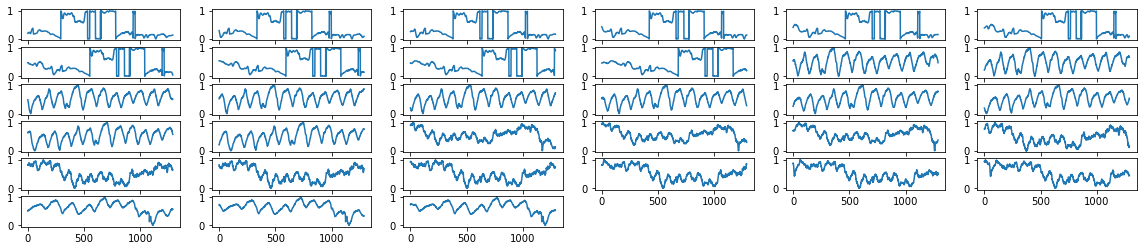

<Figure size 432x288 with 0 Axes>

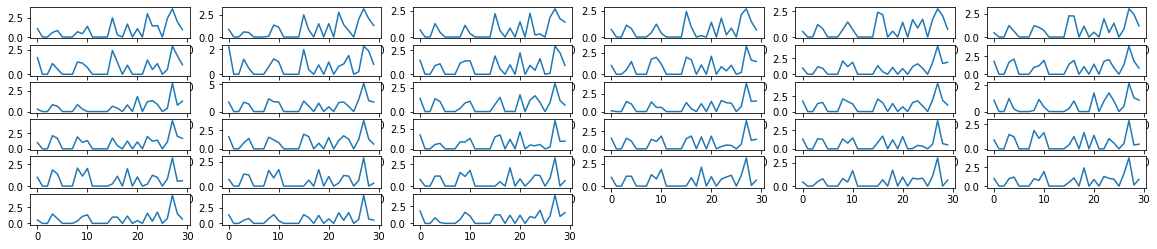

In [23]:
data2 = sp_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Store the encoded representations in the data dictionary:

In [24]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    sp_data = sp_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['sparse_encoded'] = sp_data

#### Deep Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [25]:
def deep_ae(x, enc_layers=[512,128], encoding_dim=64, dec_layers=[128,512], encoded_as_model=False):
    # From https://www.tensorflow.org/guide/keras/functional#use_the_same_graph_of_layers_to_define_multiple_models
    input_data = keras.Input(shape=x[0].shape, name="normalized_signal")
    model = Dropout(0.125, name="dropout", autocast=False, seed=42)(input_data)
    for i in enumerate(enc_layers):
        model = Dense(i[1], activation="relu", name="dense_enc_" + str(i[0]+1))(model)
    encoded_output = Dense(encoding_dim, activation="relu", name="encoded_signal")(model)

    encoded = encoded_output

    model = layers.Dense(dec_layers[0], activation="sigmoid", name="dense_dec_1")(encoded_output)
    for i in enumerate(dec_layers[1:]):
        model = Dense(i[1], activation="sigmoid", name="dense_dec_" + str(i[0]+2))(model)
    decoded_output = Dense(x[0].shape[0], activation="sigmoid", name="reconstructed_signal")(model)
    
    autoencoder = Model(input_data, decoded_output, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)

    return autoencoder, encoded

Train autoencoder on data:

In [26]:
clear_session_and_set_seeds()
de_ae, de_enc = deep_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
de_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

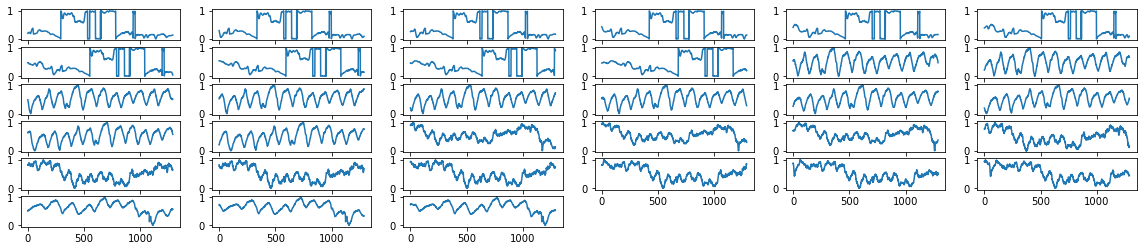

<Figure size 432x288 with 0 Axes>

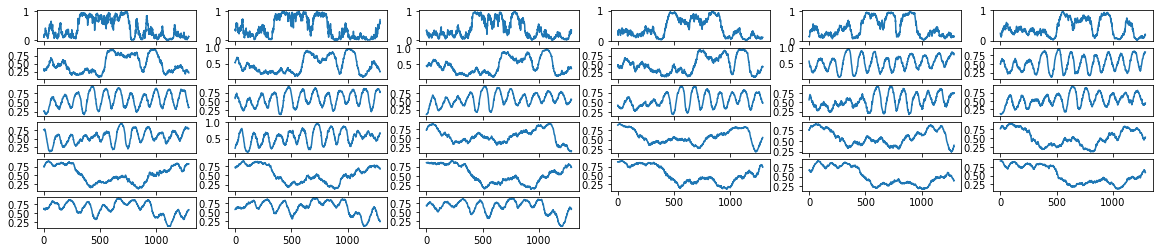

In [27]:
data2 = de_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

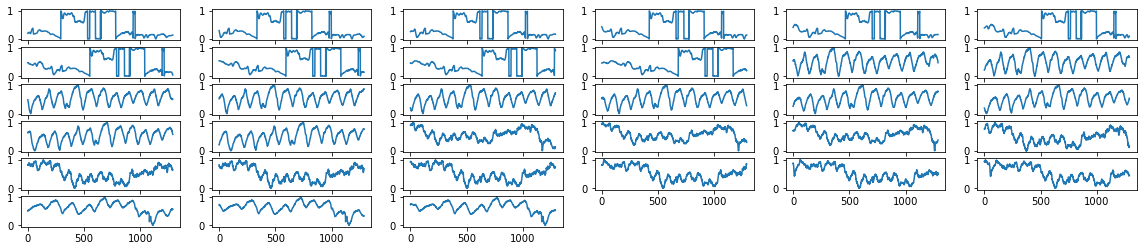

<Figure size 432x288 with 0 Axes>

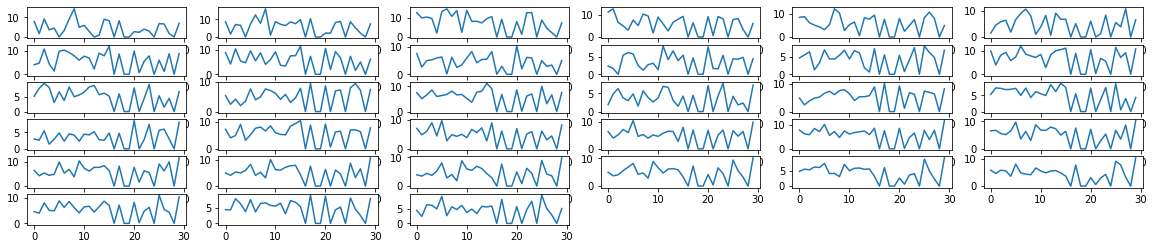

In [28]:
data2 = de_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Store the encoded representations in the data dictionary:

In [29]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    de_data = de_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['deep_encoded'] = de_data

Helper function to get data from the dictionary:

In [30]:
def get_ident_data_from_dict(idents, data_dict):
    
    # Initialize data variables
    y = y_shape.copy()
    phase = phase_shape.copy()
    breathing = breathing_shape.copy()
    heartbeat = heartbeat_shape.copy()
    combined = combined_shape.copy()
    undercomplete_encoded = ae_encoded_shape.copy()
    sparse_encoded = ae_encoded_shape.copy()
    deep_encoded = ae_encoded_shape.copy()
    
    # Stack data form each ident into the variables
    for tmp_id in idents:
        y = np.vstack((y, data_dict[tmp_id]['y']))
        phase = np.vstack((phase, data_dict[tmp_id]['phase']))
        breathing = np.vstack((breathing, data_dict[tmp_id]['breathing']))
        heartbeat = np.vstack((heartbeat, data_dict[tmp_id]['heartbeat']))
        combined = np.vstack((combined, data_dict[tmp_id]['combined']))
        undercomplete_encoded = np.vstack((undercomplete_encoded, data_dict[tmp_id]['undercomplete_encoded']))
        sparse_encoded = np.vstack((sparse_encoded, data_dict[tmp_id]['sparse_encoded']))
        deep_encoded = np.vstack((deep_encoded, data_dict[tmp_id]['deep_encoded']))
    
    return y, phase, breathing, heartbeat, combined, undercomplete_encoded, sparse_encoded, deep_encoded

## Classifiers

#### Helper loop function definition  
A function that loops over all the data and calls the classifiers with it then stores the returned accuracies.

In [31]:
def helper_loop(classifier_function_train, idents, n=5, num_loops_to_average_over=1, should_scale_data=True):
    #returns a dictionary with accuracies

    # set the variables in the dictionary
    accs = {}
    accs['phase'] = []
    accs['breathing'] = []
    accs['heartbeat'] = []
    accs['combined br hb'] = []
    accs['undercomplete'] = []
    accs['sparse'] = []
    accs['deep'] = []
    accs['test id'] = []
    start_time = datetime.now()

    # leave out person out validation
    for i in range(n):
        
        # print current iteration and time elapsed from start
        print("iteration:", i+1, "of", n, "; time elapsed:", datetime.now()-start_time)

        ## ----- Data preparation:
        validation_idents = [idents[i]]
        test_idents = [idents[i-1]]
        
        train_idents = []
        for ident in idents:
            if (ident not in test_idents) and (ident not in validation_idents):
                train_idents.append(ident)

        # save test id to see which id yielded which accuracies
        accs['test id'].append(test_idents[0])

        # Load train data
        train_data = get_ident_data_from_dict(train_idents, data_dict)
        y_train = train_data[0]
        
        # Load validation data
        valid_data = get_ident_data_from_dict(validation_idents, data_dict)
        y_valid = valid_data[0]

        # Load test data
        test_data = get_ident_data_from_dict(test_idents, data_dict)
        y_test = test_data[0]
        
        data_names_by_index = ['y', 'phase', 'breathing', 'heartbeat',
                                   'combined br hb', 'undercomplete', 'sparse', 'deep']

        # Loop over all data that will be used for classification and send it to the classifier
        # index 0 is y so we skip it
        for index in range(1, len(test_data)):
            clear_session_and_set_seeds()
            train_x = train_data[index]
            valid_x = valid_data[index]
            test_x = test_data[index]
            
            # Scale data
            if should_scale_data:
                # Scale with standard scaler
                sscaler = StandardScaler()
                sscaler.fit(train_x)
                train_x = sscaler.transform(train_x)

                # Scale valid and test with train's scaler
                valid_x = sscaler.transform(valid_x)
                test_x = sscaler.transform(test_x)
            
            # Initialize variables
            tmp_acc = []
            data_name = data_names_by_index[index]
            
            for tmp_index in range(num_loops_to_average_over):
                curr_acc = classifier_function_train(train_x, y_train, valid_x, y_valid, test_x, y_test, data_name)
                tmp_acc.append(curr_acc)
            
            # Store accuracy
            curr_acc = np.mean(tmp_acc)
            accs[data_name].append(curr_acc)
        

    # Print total time required to run this
    end_time = datetime.now()
    elapsed_time = end_time - start_time
    print("Completed!", "Time elapsed:", elapsed_time)
    
    return accs

#### Simple dense classifier

Define the classifier:

In [39]:
params_dense_phase = {
    'dropout': 0.4,
    'hidden_size': 26,
    'activation': 'sigmoid',
    'loss': 'categorical_crossentropy',
    'optimizer': Adam,
    'batch_size': 128,
    'learning_rate': 0.001,
    'epochs': 300
}

In [44]:
params_dense_br_hb = {
    'dropout': 0.05,
    'hidden_size': 24,
    'activation': 'sigmoid',
    'loss': 'categorical_crossentropy',
    'optimizer': Nadam,
    'learning_rate': 0.05,
    'batch_size': 128,
    'epochs': 100
}

In [41]:
params_dense_ae_enc = {
    'dropout': 0.05,
    'hidden_size': 34,
    'activation': 'relu',
    'loss': 'categorical_crossentropy',
    'optimizer': Adam,
    'learning_rate': 0.005,
    'batch_size': 106,
    'epochs': 200
}

In [47]:
def dense_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    # change Ys to categorical (one hot encoding)
    y_train = to_categorical(y_train)
    y_valid = to_categorical(y_valid)
    y_test = to_categorical(y_test)
    
    params = params_dense_br_hb
    if (data_name == 'phase'):
        params = params_dense_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_dense_ae_enc
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['hidden_size']))
    model.add(Activation(params['activation']))
    model.add(Dense(3))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=metrics)
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, x_train, y_train, params['batch_size'], params['epochs'],
                                           x_valid, y_valid, x_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [48]:
accs = helper_loop(dense_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:01:00.413885
iteration: 3 of 23 ; time elapsed: 0:02:00.335251
iteration: 4 of 23 ; time elapsed: 0:03:01.276746
iteration: 5 of 23 ; time elapsed: 0:04:26.222401
iteration: 6 of 23 ; time elapsed: 0:05:37.643844
iteration: 7 of 23 ; time elapsed: 0:07:01.555042
iteration: 8 of 23 ; time elapsed: 0:08:41.902385
iteration: 9 of 23 ; time elapsed: 0:09:54.551415
iteration: 10 of 23 ; time elapsed: 0:10:54.994596
iteration: 11 of 23 ; time elapsed: 0:11:55.455919
iteration: 12 of 23 ; time elapsed: 0:12:58.791831
iteration: 13 of 23 ; time elapsed: 0:14:03.546511
iteration: 14 of 23 ; time elapsed: 0:15:07.812978
iteration: 15 of 23 ; time elapsed: 0:16:12.663674
iteration: 16 of 23 ; time elapsed: 0:17:17.938773
iteration: 17 of 23 ; time elapsed: 0:18:28.134230
iteration: 18 of 23 ; time elapsed: 0:19:34.349590
iteration: 19 of 23 ; time elapsed: 0:20:41.420977
iteration: 20 of 23 ; time elapsed: 0:21:48.532

In [49]:
accuracies['simple_dense'] = accs

In [50]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.344444,0.350000,0.383333,0.433333,0.233333,0.388889,0.355556,62i9y
1,0.300000,0.255556,0.266667,0.333333,0.361111,0.333333,0.383333,2gu87
2,0.300000,0.238889,0.316667,0.266667,0.294444,0.327778,0.288889,iz2ps
3,0.316667,0.194444,0.294444,0.272222,0.294444,0.416667,0.383333,1mpau
4,0.350000,0.244444,0.350000,0.333333,0.316667,0.277778,0.411111,7dwjy
5,0.344444,0.322222,0.388889,0.238889,0.300000,0.344444,0.344444,7swyk
6,0.366667,0.255556,0.316667,0.427778,0.400000,0.416667,0.338889,94mnx
7,0.366667,0.422222,0.333333,0.405556,0.333333,0.322222,0.416667,bd47a
8,0.377778,0.355556,0.377778,0.338889,0.350000,0.344444,0.372222,c24ur
9,0.272222,0.272222,0.294444,0.238889,0.400000,0.266667,0.283333,ctsax


In [51]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.272222   0.194444   0.238889        0.238889       0.200000  0.266667  0.266667
max     0.455556   0.511111   0.433333        0.527778       0.444444  0.461111  0.416667
mean    0.358454   0.319565   0.335266        0.334058       0.327536  0.359420  0.350725
median  0.344444   0.300000   0.333333        0.322222       0.333333  0.344444  0.355556


#### LSTM-based classifier  
based on the original author's code

In [52]:
params_lstm_phase = {
    'kernel_size': 4,
    'filters': 32,
    'strides': 2,
    'pool_size': 4,
    'dropout': 0.1,
    'lstm_output_size': 22,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'categorical_crossentropy',
    'optimizer': Nadam,
    'learning_rate': 0.005,
    'batch_size': 168,
    'epochs': 200
}

In [53]:
params_lstm_br_hb = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 1,
    'dropout': 0.01,
    'lstm_output_size': 64,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'categorical_crossentropy',
    'optimizer': Nadam,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 100
}

In [54]:
params_lstm_ae_enc = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 2,
    'dropout': 0.01,
    'lstm_output_size': 32,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'categorical_crossentropy',
    'optimizer': Nadam,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 100
}

In [55]:
def LSTM_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    # change Ys to categorical (one hot encoding)
    y_train = to_categorical(y_train)
    y_valid = to_categorical(y_valid)
    y_test = to_categorical(y_test)
    
    params = params_lstm_br_hb
    if (data_name == 'phase'):
        params = params_lstm_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_lstm_ae_enc
    
    # Reshape data to fit some layers
    xt_train = x_train.reshape(-1, x_train[0].shape[0], 1)
    xt_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
    xt_test = x_test.reshape(-1, x_test[0].shape[0], 1)
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))

    model.add(MaxPooling1D(pool_size=params['pool_size']))
    
    if (data_name == 'phase'):
        model.add(Conv1D(params['filters'],
                         params['kernel_size'],
                         padding='valid',
                         activation=params['activation'],
                         strides=params['strides']))
        model.add(MaxPooling1D(pool_size=params['pool_size']))

    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['lstm_output_size']))
    model.add(Dense(3))
    model.add(Activation(params['last_activation']))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=['acc'])
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, xt_train, y_train, params['batch_size'], params['epochs'],
                                           xt_valid, y_valid, xt_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [56]:
accs = helper_loop(LSTM_train, idents, n=n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:05:56.402829
iteration: 3 of 23 ; time elapsed: 0:11:48.294163
iteration: 4 of 23 ; time elapsed: 0:17:42.005135
iteration: 5 of 23 ; time elapsed: 0:23:42.852089
iteration: 6 of 23 ; time elapsed: 0:30:05.925559
iteration: 7 of 23 ; time elapsed: 0:36:35.370706
iteration: 8 of 23 ; time elapsed: 0:42:39.358425
iteration: 9 of 23 ; time elapsed: 0:47:56.497059
iteration: 10 of 23 ; time elapsed: 0:52:56.571152
iteration: 11 of 23 ; time elapsed: 0:57:55.818563
iteration: 12 of 23 ; time elapsed: 1:02:59.914291
iteration: 13 of 23 ; time elapsed: 1:07:58.581915
iteration: 14 of 23 ; time elapsed: 1:13:48.642930
iteration: 15 of 23 ; time elapsed: 1:22:09.519735
iteration: 16 of 23 ; time elapsed: 1:28:02.620613
iteration: 17 of 23 ; time elapsed: 1:33:54.496702
iteration: 18 of 23 ; time elapsed: 1:39:37.796400
iteration: 19 of 23 ; time elapsed: 1:45:26.062933
iteration: 20 of 23 ; time elapsed: 1:51:55.764

In [57]:
accuracies['LSTM'] = accs

In [58]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.250000,0.400000,0.372222,0.411111,0.288889,0.344444,0.416667,62i9y
1,0.216667,0.333333,0.372222,0.361111,0.250000,0.294444,0.361111,2gu87
2,0.205556,0.333333,0.327778,0.411111,0.255556,0.311111,0.266667,iz2ps
3,0.366667,0.366667,0.277778,0.288889,0.394444,0.444444,0.400000,1mpau
4,0.250000,0.311111,0.333333,0.250000,0.350000,0.305556,0.211111,7dwjy
5,0.311111,0.422222,0.305556,0.283333,0.333333,0.261111,0.383333,7swyk
6,0.566667,0.294444,0.233333,0.305556,0.294444,0.266667,0.261111,94mnx
7,0.394444,0.400000,0.277778,0.333333,0.277778,0.338889,0.322222,bd47a
8,0.200000,0.405556,0.377778,0.394444,0.216667,0.288889,0.361111,c24ur
9,0.400000,0.277778,0.250000,0.338889,0.338889,0.305556,0.338889,ctsax


In [59]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.177778   0.272222   0.211111        0.233333       0.216667  0.216667  0.211111
max     0.566667   0.438889   0.433333        0.533333       0.444444  0.472222  0.477778
mean    0.334058   0.354589   0.325121        0.338889       0.322222  0.336957  0.336232
median  0.350000   0.361111   0.327778        0.333333       0.333333  0.338889  0.333333


#### kNN

In [60]:
params_knn_phase = {
    'n_neighbors': 5,
    'metric': 'cosine'
}

In [61]:
params_knn_br_hb = {
    'n_neighbors': 15,
    'metric': 'manhattan'
}

In [62]:
params_knn_ae_enc = {
    'n_neighbors': 15,
    'metric': 'cosine'
}

In [63]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_classifier(params):
    model = KNeighborsClassifier(n_neighbors=params['n_neighbors'], metric=params['metric'])
    return model

In [64]:
def KNN_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_knn_br_hb
    if (data_name == 'phase'):
        params = params_knn_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_knn_ae_enc
    
    model = OneVsRestClassifier(KNN_classifier(params))
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [65]:
accs = helper_loop(KNN_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:01.059166
iteration: 3 of 23 ; time elapsed: 0:00:02.132293
iteration: 4 of 23 ; time elapsed: 0:00:03.159546
iteration: 5 of 23 ; time elapsed: 0:00:04.184801
iteration: 6 of 23 ; time elapsed: 0:00:05.214047
iteration: 7 of 23 ; time elapsed: 0:00:06.243292
iteration: 8 of 23 ; time elapsed: 0:00:07.280516
iteration: 9 of 23 ; time elapsed: 0:00:08.266115
iteration: 10 of 23 ; time elapsed: 0:00:09.217200
iteration: 11 of 23 ; time elapsed: 0:00:10.150207
iteration: 12 of 23 ; time elapsed: 0:00:11.292153
iteration: 13 of 23 ; time elapsed: 0:00:12.376381
iteration: 14 of 23 ; time elapsed: 0:00:14.153625
iteration: 15 of 23 ; time elapsed: 0:00:15.961314
iteration: 16 of 23 ; time elapsed: 0:00:17.708637
iteration: 17 of 23 ; time elapsed: 0:00:19.401109
iteration: 18 of 23 ; time elapsed: 0:00:21.180346
iteration: 19 of 23 ; time elapsed: 0:00:22.807991
iteration: 20 of 23 ; time elapsed: 0:00:24.435

In [66]:
accuracies['kNN'] = accs

In [67]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.350000,0.333333,0.255556,0.344444,0.344444,0.433333,0.422222,62i9y
1,0.555556,0.288889,0.400000,0.427778,0.188889,0.266667,0.327778,2gu87
2,0.344444,0.311111,0.233333,0.372222,0.361111,0.427778,0.283333,iz2ps
3,0.411111,0.361111,0.300000,0.294444,0.361111,0.488889,0.444444,1mpau
4,0.261111,0.288889,0.350000,0.227778,0.366667,0.350000,0.288889,7dwjy
5,0.361111,0.250000,0.355556,0.333333,0.327778,0.355556,0.372222,7swyk
6,0.433333,0.377778,0.361111,0.383333,0.294444,0.327778,0.338889,94mnx
7,0.294444,0.383333,0.388889,0.266667,0.227778,0.288889,0.372222,bd47a
8,0.388889,0.277778,0.383333,0.411111,0.344444,0.300000,0.266667,c24ur
9,0.294444,0.300000,0.261111,0.388889,0.400000,0.300000,0.283333,ctsax


In [68]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.177778   0.200000   0.211111        0.177778       0.188889  0.244444  0.227778
max     0.561111   0.388889   0.450000        0.494444       0.427778  0.488889  0.444444
mean    0.353140   0.308937   0.327053        0.335749       0.332609  0.334541  0.333575
median  0.355556   0.311111   0.350000        0.333333       0.344444  0.327778  0.327778


####  SVC

In [69]:
params_svc_phase = {
    'C': 10,
    'kernel': 'rbf',
    'gamma': 'scale'
}

In [70]:
params_svc_br_hb = {
    'C': 2,
    'kernel': 'rbf',
    'gamma': 'auto'
}

In [71]:
params_svc_ae_enc = {
    'C': 3,
    'kernel': 'rbf',
    'gamma': 'auto'
}

In [72]:
from sklearn.svm import SVC

def SVC_classifier(params):
    model = SVC(random_state=42, C=params['C'], kernel=params['kernel'], gamma=params['gamma'])
    return model

In [73]:
def SVC_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_svc_br_hb
    if (data_name == 'phase'):
        params = params_svc_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_svc_ae_enc
    
    model = OneVsRestClassifier(SVC_classifier(params))
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [74]:
accs = helper_loop(SVC_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:01:43.871651
iteration: 3 of 23 ; time elapsed: 0:02:52.401264
iteration: 4 of 23 ; time elapsed: 0:04:44.969031
iteration: 5 of 23 ; time elapsed: 0:05:54.243679
iteration: 6 of 23 ; time elapsed: 0:07:30.767352
iteration: 7 of 23 ; time elapsed: 0:08:54.855330
iteration: 8 of 23 ; time elapsed: 0:10:12.487587
iteration: 9 of 23 ; time elapsed: 0:11:55.217678
iteration: 10 of 23 ; time elapsed: 0:13:03.334397
iteration: 11 of 23 ; time elapsed: 0:14:54.595659
iteration: 12 of 23 ; time elapsed: 0:16:02.931819
iteration: 13 of 23 ; time elapsed: 0:17:39.690862
iteration: 14 of 23 ; time elapsed: 0:19:02.775527
iteration: 15 of 23 ; time elapsed: 0:20:23.575306
iteration: 16 of 23 ; time elapsed: 0:22:07.611648
iteration: 17 of 23 ; time elapsed: 0:23:16.600034
iteration: 18 of 23 ; time elapsed: 0:25:09.034180
iteration: 19 of 23 ; time elapsed: 0:26:17.499943
iteration: 20 of 23 ; time elapsed: 0:27:59.204

In [75]:
accuracies['SVC'] = accs

In [76]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.316667,0.411111,0.438889,0.455556,0.338889,0.250000,0.116667,62i9y
1,0.261111,0.300000,0.511111,0.450000,0.338889,0.322222,0.311111,2gu87
2,0.411111,0.227778,0.216667,0.377778,0.222222,0.327778,0.416667,iz2ps
3,0.355556,0.366667,0.238889,0.283333,0.350000,0.350000,0.388889,1mpau
4,0.261111,0.188889,0.361111,0.461111,0.244444,0.272222,0.316667,7dwjy
5,0.372222,0.261111,0.316667,0.305556,0.350000,0.344444,0.305556,7swyk
6,0.327778,0.394444,0.200000,0.394444,0.266667,0.427778,0.333333,94mnx
7,0.427778,0.322222,0.427778,0.266667,0.305556,0.327778,0.244444,bd47a
8,0.288889,0.277778,0.372222,0.388889,0.150000,0.227778,0.238889,c24ur
9,0.227778,0.327778,0.272222,0.277778,0.305556,0.338889,0.316667,ctsax


In [77]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.216667   0.188889   0.200000        0.261111       0.150000  0.227778  0.116667
max     0.438889   0.488889   0.511111        0.633333       0.516667  0.427778  0.477778
mean    0.343237   0.319565   0.341787        0.373188       0.324638  0.333333  0.322464
median  0.355556   0.322222   0.344444        0.366667       0.338889  0.344444  0.316667


#### Random Forest

In [78]:
params_rf_phase = {
    'n_estimators': 180,
    'max_depth': 50,
    'min_samples_split': 4,
    'min_samples_leaf': 1,
    'oob_score': False,
    'ccp_alpha': 0.001
}

In [79]:
params_rf_br_hb = {
    'n_estimators': 180,
    'max_depth': None,
    'min_samples_split': 3,
    'min_samples_leaf': 3,
    'oob_score': False,
    'ccp_alpha': 0.005
}

In [80]:
params_rf_ae_enc = {
    'n_estimators': 130,
    'max_depth': 100,
    'min_samples_split': 5,
    'min_samples_leaf': 5,
    'oob_score': True,
    'ccp_alpha': 0.005
}

In [81]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier(params):
    model = RandomForestClassifier(random_state=42,
                                   n_estimators = params['n_estimators'],
                                   criterion = 'entropy',
                                   max_depth = params['max_depth'],
                                   min_samples_split = params['min_samples_split'],
                                   min_samples_leaf = params['min_samples_leaf'],
                                   oob_score = params['oob_score'],
                                   ccp_alpha = params['ccp_alpha'],
                                   max_features = 'log2',
                                   bootstrap = True)
    return model

In [82]:
def random_forest_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_rf_br_hb
    if (data_name == 'phase'):
        params = params_rf_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_rf_ae_enc
    
    model = OneVsRestClassifier(random_forest_classifier(params))
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [83]:
accs = helper_loop(random_forest_train, idents, n, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:01:51.520596
iteration: 3 of 23 ; time elapsed: 0:02:59.248327
iteration: 4 of 23 ; time elapsed: 0:04:47.563473
iteration: 5 of 23 ; time elapsed: 0:06:00.123302
iteration: 6 of 23 ; time elapsed: 0:07:31.129767
iteration: 7 of 23 ; time elapsed: 0:08:57.194456
iteration: 8 of 23 ; time elapsed: 0:10:15.962672
iteration: 9 of 23 ; time elapsed: 0:11:57.778212
iteration: 10 of 23 ; time elapsed: 0:13:07.303162
iteration: 11 of 23 ; time elapsed: 0:14:58.338031
iteration: 12 of 23 ; time elapsed: 0:16:08.820419
iteration: 13 of 23 ; time elapsed: 0:18:00.730945
iteration: 14 of 23 ; time elapsed: 0:19:14.323012
iteration: 15 of 23 ; time elapsed: 0:20:21.150020
iteration: 16 of 23 ; time elapsed: 0:21:20.583736
iteration: 17 of 23 ; time elapsed: 0:22:21.077427
iteration: 18 of 23 ; time elapsed: 0:23:23.891046
iteration: 19 of 23 ; time elapsed: 0:24:28.501030
iteration: 20 of 23 ; time elapsed: 0:25:32.551

In [84]:
accuracies['random_forest'] = accs

In [85]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.333333,0.355556,0.450000,0.383333,0.211111,0.272222,0.333333,62i9y
1,0.266667,0.361111,0.388889,0.300000,0.261111,0.333333,0.311111,2gu87
2,0.422222,0.372222,0.216667,0.322222,0.222222,0.244444,0.294444,iz2ps
3,0.505556,0.366667,0.294444,0.188889,0.433333,0.400000,0.394444,1mpau
4,0.311111,0.338889,0.383333,0.338889,0.322222,0.311111,0.172222,7dwjy
5,0.183333,0.272222,0.416667,0.322222,0.255556,0.250000,0.244444,7swyk
6,0.411111,0.427778,0.361111,0.411111,0.238889,0.361111,0.211111,94mnx
7,0.327778,0.394444,0.411111,0.433333,0.233333,0.272222,0.333333,bd47a
8,0.227778,0.283333,0.488889,0.388889,0.261111,0.350000,0.311111,c24ur
9,0.383333,0.272222,0.216667,0.166667,0.311111,0.305556,0.288889,ctsax


In [86]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.183333   0.205556   0.216667        0.166667       0.211111  0.205556  0.144444
max     0.505556   0.466667   0.488889        0.516667       0.444444  0.450000  0.427778
mean    0.351208   0.347343   0.353865        0.347585       0.290580  0.320773  0.305072
median  0.355556   0.355556   0.361111        0.366667       0.277778  0.316667  0.311111


#### Naive Bayesian

In [87]:
from sklearn.naive_bayes import GaussianNB

def naive_bayesian_classifier():
    model = GaussianNB()
    return model

In [88]:
def naive_bayesian_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = OneVsRestClassifier(naive_bayesian_classifier())
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [89]:
accs = helper_loop(naive_bayesian_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.714613
iteration: 3 of 23 ; time elapsed: 0:00:01.435716
iteration: 4 of 23 ; time elapsed: 0:00:02.146843
iteration: 5 of 23 ; time elapsed: 0:00:02.854983
iteration: 6 of 23 ; time elapsed: 0:00:03.615471
iteration: 7 of 23 ; time elapsed: 0:00:04.379462
iteration: 8 of 23 ; time elapsed: 0:00:05.080625
iteration: 9 of 23 ; time elapsed: 0:00:05.810794
iteration: 10 of 23 ; time elapsed: 0:00:06.522414
iteration: 11 of 23 ; time elapsed: 0:00:07.201629
iteration: 12 of 23 ; time elapsed: 0:00:07.977586
iteration: 13 of 23 ; time elapsed: 0:00:08.749551
iteration: 14 of 23 ; time elapsed: 0:00:09.458690
iteration: 15 of 23 ; time elapsed: 0:00:10.146377
iteration: 16 of 23 ; time elapsed: 0:00:10.835571
iteration: 17 of 23 ; time elapsed: 0:00:11.531238
iteration: 18 of 23 ; time elapsed: 0:00:12.260320
iteration: 19 of 23 ; time elapsed: 0:00:12.953497
iteration: 20 of 23 ; time elapsed: 0:00:13.656

In [90]:
accuracies['naive_bayesian'] = accs

In [91]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.333333,0.283333,0.488889,0.350000,0.277778,0.300000,0.233333,62i9y
1,0.316667,0.338889,0.372222,0.327778,0.311111,0.305556,0.333333,2gu87
2,0.433333,0.211111,0.288889,0.194444,0.327778,0.350000,0.322222,iz2ps
3,0.311111,0.283333,0.200000,0.250000,0.211111,0.300000,0.288889,1mpau
4,0.322222,0.294444,0.294444,0.294444,0.338889,0.266667,0.327778,7dwjy
5,0.333333,0.244444,0.366667,0.405556,0.383333,0.277778,0.327778,7swyk
6,0.294444,0.355556,0.350000,0.322222,0.288889,0.394444,0.411111,94mnx
7,0.361111,0.277778,0.344444,0.411111,0.322222,0.333333,0.333333,bd47a
8,0.333333,0.333333,0.355556,0.438889,0.338889,0.355556,0.372222,c24ur
9,0.166667,0.250000,0.338889,0.277778,0.244444,0.161111,0.300000,ctsax


In [92]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.166667   0.211111   0.200000        0.194444       0.194444  0.161111  0.233333
max     0.433333   0.472222   0.488889        0.438889       0.405556  0.394444  0.411111
mean    0.323430   0.330193   0.353865        0.348068       0.308696  0.325362  0.332850
median  0.333333   0.327778   0.366667        0.355556       0.322222  0.333333  0.333333


#### XGBoost

In [93]:
params_xgb_phase = {
    'n_estimators': 50,
    'max_depth': 50,
    'booster': 'gbtree'
}

In [94]:
params_xgb_br_hb = {
    'n_estimators': 50,
    'max_depth': 4,
    'booster': 'gbtree'
}

In [95]:
params_xgb_ae_enc = {
    'n_estimators': 50,
    'max_depth': 5,
    'booster': 'gbtree'
}

In [96]:
from xgboost import XGBClassifier

def XGBoost_classifier(params):
    model = XGBClassifier(random_state=42,
                         n_estimators=params['n_estimators'],
                         max_depth=params['max_depth'])
    return model

In [97]:
def XGBoost_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_xgb_br_hb
    if (data_name == 'phase'):
        params = params_xgb_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_xgb_ae_enc
    
    model = OneVsRestClassifier(XGBoost_classifier(params))
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [98]:
accs = helper_loop(XGBoost_train, idents, n, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:01:30.448965
iteration: 3 of 23 ; time elapsed: 0:03:13.196675
iteration: 4 of 23 ; time elapsed: 0:04:50.212358
iteration: 5 of 23 ; time elapsed: 0:06:30.205471
iteration: 6 of 23 ; time elapsed: 0:07:49.376471
iteration: 7 of 23 ; time elapsed: 0:08:44.967624
iteration: 8 of 23 ; time elapsed: 0:09:41.659023
iteration: 9 of 23 ; time elapsed: 0:10:38.193618
iteration: 10 of 23 ; time elapsed: 0:11:35.155881
iteration: 11 of 23 ; time elapsed: 0:12:34.821883
iteration: 12 of 23 ; time elapsed: 0:13:34.672769
iteration: 13 of 23 ; time elapsed: 0:14:33.304387
iteration: 14 of 23 ; time elapsed: 0:15:33.625736
iteration: 15 of 23 ; time elapsed: 0:16:33.759940
iteration: 16 of 23 ; time elapsed: 0:17:30.826210
iteration: 17 of 23 ; time elapsed: 0:18:25.041194
iteration: 18 of 23 ; time elapsed: 0:19:21.310224
iteration: 19 of 23 ; time elapsed: 0:20:15.945359
iteration: 20 of 23 ; time elapsed: 0:21:10.913

In [99]:
accuracies['XGBoost'] = accs

In [100]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.377778,0.377778,0.400000,0.433333,0.350000,0.372222,0.427778,62i9y
1,0.255556,0.322222,0.461111,0.422222,0.327778,0.333333,0.288889,2gu87
2,0.366667,0.366667,0.211111,0.338889,0.361111,0.411111,0.372222,iz2ps
3,0.483333,0.383333,0.300000,0.333333,0.394444,0.416667,0.411111,1mpau
4,0.300000,0.322222,0.316667,0.366667,0.355556,0.300000,0.338889,7dwjy
5,0.211111,0.350000,0.427778,0.422222,0.261111,0.188889,0.300000,7swyk
6,0.383333,0.450000,0.272222,0.416667,0.316667,0.355556,0.322222,94mnx
7,0.344444,0.433333,0.461111,0.422222,0.272222,0.366667,0.388889,bd47a
8,0.288889,0.266667,0.405556,0.433333,0.255556,0.216667,0.250000,c24ur
9,0.327778,0.294444,0.216667,0.283333,0.422222,0.394444,0.338889,ctsax


In [101]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.211111   0.200000   0.211111        0.227778       0.244444  0.188889  0.222222
max     0.483333   0.488889   0.461111        0.488889       0.422222  0.488889  0.427778
mean    0.346377   0.352899   0.345169        0.369807       0.332609  0.347826  0.322705
median  0.355556   0.350000   0.338889        0.388889       0.338889  0.350000  0.322222


###  Compare Accuracies

Print min, max, mean, median for each clasifier/autoencoder combination:

In [102]:
for classifier in accuracies:
    print("-----------", classifier + ":", "-----------")
    accs = accuracies[classifier]
    print_accs_stats(accs)
    print("\n")

----------- simple_dense: -----------
           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.272222   0.194444   0.238889        0.238889       0.200000  0.266667  0.266667
max     0.455556   0.511111   0.433333        0.527778       0.444444  0.461111  0.416667
mean    0.358454   0.319565   0.335266        0.334058       0.327536  0.359420  0.350725
median  0.344444   0.300000   0.333333        0.322222       0.333333  0.344444  0.355556


----------- LSTM: -----------
           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.177778   0.272222   0.211111        0.233333       0.216667  0.216667  0.211111
max     0.566667   0.438889   0.433333        0.533333       0.444444  0.472222  0.477778
mean    0.334058   0.354589   0.325121        0.338889       0.322222  0.336957  0.336232
median  0.350000   0.361111   0.327778        0.333333       0.333333  0.338889  0.333333


----------- kNN: -----------

Print all accuracies in table form:

In [103]:
for classifier in accuracies:
    print(classifier + ":")
#     print(pandas.DataFrame.from_dict(accuracies[classifier]))
    # Using .to_string() gives nicer loooking results (doesn't split into new line)
    print(pandas.DataFrame.from_dict(accuracies[classifier]).to_string())
    print("\n")

simple_dense:
       phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep test id
0   0.344444   0.350000   0.383333        0.433333       0.233333  0.388889  0.355556   62i9y
1   0.300000   0.255556   0.266667        0.333333       0.361111  0.333333  0.383333   2gu87
2   0.300000   0.238889   0.316667        0.266667       0.294444  0.327778  0.288889   iz2ps
3   0.316667   0.194444   0.294444        0.272222       0.294444  0.416667  0.383333   1mpau
4   0.350000   0.244444   0.350000        0.333333       0.316667  0.277778  0.411111   7dwjy
5   0.344444   0.322222   0.388889        0.238889       0.300000  0.344444  0.344444   7swyk
6   0.366667   0.255556   0.316667        0.427778       0.400000  0.416667  0.338889   94mnx
7   0.366667   0.422222   0.333333        0.405556       0.333333  0.322222  0.416667   bd47a
8   0.377778   0.355556   0.377778        0.338889       0.350000  0.344444  0.372222   c24ur
9   0.272222   0.272222   0.294444        0.23